In [2]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
# from cycler import cycler
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('clarke-default')

from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
from scipy import stats

# plt.rcParams.update({'figure.dpi': 150})
# plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
#                                                       '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Load the config file and add new parameters

In [50]:
# drive_path = '/Users/clarke/Data'
drive_path = '/Volumes/LaCie/'

sphere_date = '20260215'
data_type = 'xenon'

base_path = f'{drive_path}/gas_collisions/pulse_calibration/sphere_{sphere_date}/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

config_dirs = glob(f'configs/sphere_{sphere_date}/*')

[print(i) for i in config_dirs]
print()

config_ind = -1

with open(config_dirs[config_ind] + '/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['calibrate'] = False

template = np.array(config['template'])
resolution = config['resolution']

for key in config.keys():
    print(key + ':\t ', config[key])

configs/sphere_20260215/20260216_p6e_6e-8mbar_d137khz_0
configs/sphere_20260215/20260219_p6e_4e-8mbar_d137khz_0

apply_notch:	  False
calibrate:	  False
d_sphere_nm:	  100.0
f_cutoff:	  [25000.0, 100000.0]
fit_window:	  0.1
keV_per_N:	  3.1897882840718262e+19
meters_per_volt:	  2.6780049680555713e-07
resolution:	  54.52830966438975
search_window:	  5e-05
template:	  [-0.03554688564731502, -0.023924201008772506, -0.0006534584155965829, 0.027461580682985966, 0.04845874144177789, 0.050062969749404156, 0.02635605448817303, -0.01758880273759195, -0.06546955754055497, -0.09453073721084795, -0.08327786841043466, -0.020658260005773678, 0.08545057127996025, 0.20391976216843943, 0.28577199486376714, 0.2805575898383637, 0.15827685834958768, -0.07279142682848296, -0.35828755014771335, -0.6028845546018576, -0.6922507056026566, -0.5374822325337766, -0.13422514832203425, 0.39752168660973114, 0.8404509058379309, 0.9857199902753451, 0.7585276295682597, 0.2677162286864329, -0.2624424884121697, -0.623151

### List the background datasets

In [51]:
base_path = f'{drive_path}/gas_collisions/{data_type}_data/sphere_{sphere_date}/'
# base_path = f'{drive_path}/gas_collisions/pulse_calibration/sphere_{sphere_date}/'

folders = glob(base_path + '*')

bkg_datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    bkg_datasets[folder.split(base_path)[-1]] = sub_datasets

20260219_p6e_1e-7mbar
	20260219_dfg
20260219_p6e_1e-6mbar
	20260219_dfg
20260219_p6e_1e-7mbar_1
	20260219_dfg
20260219_p6e_2e-7mbar
	20260219_dfg
20260219_p6e_4e-7mbar
	20260219_dfg
20260219_p6e_4e-7mbar_1
	20260219_dfg
20260219_p6e_5e-8mbar
	20260219_dfg
20260219_p6e_7e-7mbar
20260219_p6e_7e-8mbar
	20260219_dfg
20260219_p6e_8e-7mbar
	20260219_dfg


### Load a background dataset

In [52]:
reload(dp)

# choose which dataset to look at
dataset_ind = 2
dataset = list(bkg_datasets.keys())[dataset_ind]

save_path = '/Users/clarke/Code/nanospheres/processed' + base_path.split(drive_path)[-1] + \
            dataset + '/' + bkg_datasets[dataset][0] + '_processed.hdf5'
os.makedirs('/'.join(save_path.split('/')[:-1]), exist_ok=True)

plot = False

plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + bkg_datasets[dataset][0] if plot else None
# nd = dp.NanoDataset(base_path + dataset + '/' + bkg_datasets[dataset][0], plot_path, verbose=True, max_files=25, \
#                     config=config, ds_factor=10)
# nd.load_search_data()
# nd.save_to_hdf5(save_path)

In [53]:
reload(dp)
nd = dp.NanoDataset()
nd.load_from_hdf5(save_path)

### Cut away noisy periods

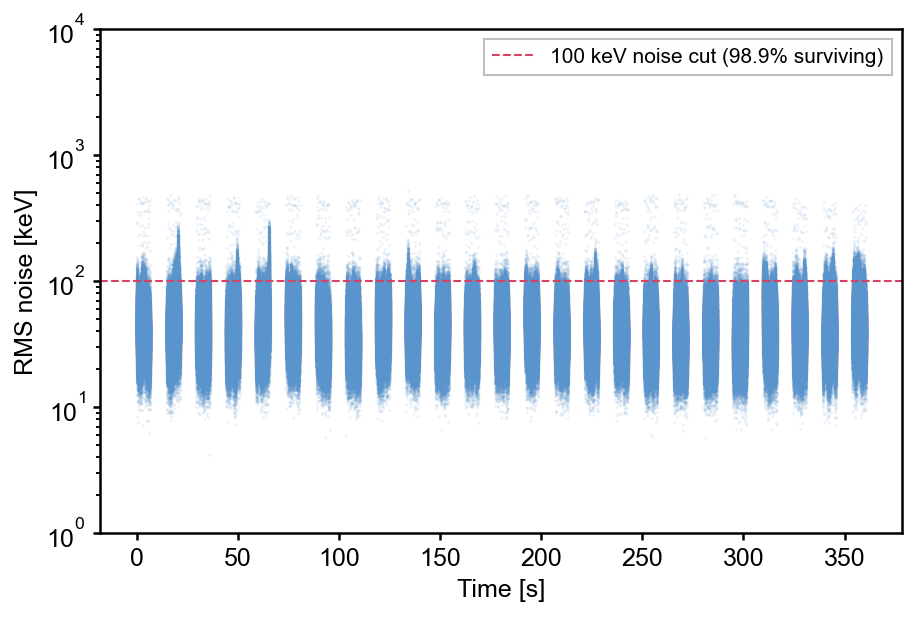

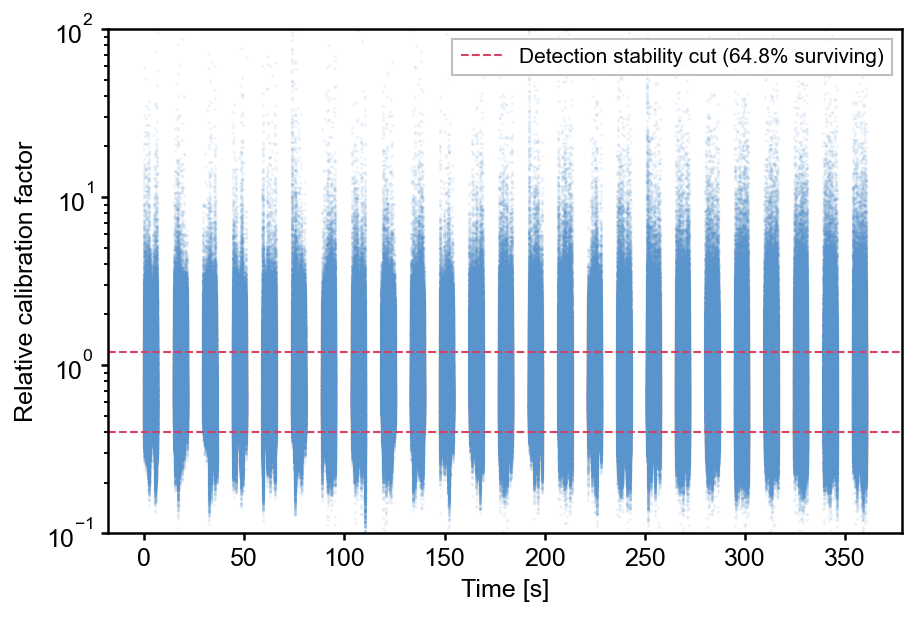

In [54]:
noise_thresh = 100 # keV

noise_mask = (nd.impulse_rms < noise_thresh) #& (nd.impulse_rms > 10)

# also cut based on the fit to the resonance
res_mask = nd.resonance_params[:, 2] < 2*np.pi*100

det_cuts = np.mean(nd.cal_facs[nd.cal_facs < 2])*(1 + np.array((-0.1, 0.1)))
det_cuts = np.array((0.4, 1.2))

det_mask = (nd.cal_facs > det_cuts[0]) & (nd.cal_facs < det_cuts[1])

plot_times = nd.pulse_times + np.repeat(nd.timestamps, len(nd.pulse_times)//len(nd.timestamps)) - np.amin(nd.timestamps)

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.semilogy(plot_times, nd.impulse_rms, marker='.', ms=1, alpha=0.1, ls='none')
ax.axhline(noise_thresh, ls='--', color='C1', label='{:.0f} keV noise cut ({:.1f}% surviving)'\
                                                    .format(noise_thresh, 100*sum(noise_mask)/len(noise_mask)))
ax.set_xlabel('Time [s]')
ax.set_ylabel('RMS noise [keV]')
ax.set_ylim([1e0, 1e4])
ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(plot_times, nd.cal_facs, marker='.', ms=1, alpha=0.1, ls='none')
ax.axhline(det_cuts[0], ls='--', color='C1', label='Detection stability cut ({:.1f}% surviving)'.format(100*sum(det_mask)/len(det_mask)))
ax.axhline(det_cuts[1], ls='--', color='C1')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Relative calibration factor')
ax.set_ylim([1e-1, 1e2])
ax.set_yscale('log')
ax.legend(loc='upper right')

In [55]:
file_breaks = np.concat(((0,), np.argwhere(np.diff(nd.deliv_times) < 0)[:, 0]))
deliv_times = np.copy(nd.deliv_times)

for i in range(len(file_breaks)):
    if i + 1 >= len(file_breaks):
        deliv_times[file_breaks[i] + 1:] += nd.timestamps[i]
        continue
    deliv_times[file_breaks[i] + 1:file_breaks[i + 1] + 1] += nd.timestamps[i]

deliv_times[1:] -= np.amin(nd.timestamps)

kick_win = 1e-5
kick_mask = np.zeros(len(plot_times), dtype=bool)

# for i, pt in enumerate(plot_times):
#     kick_mask[i] = np.amin(np.abs(deliv_times - pt)) < kick_win

idx = np.searchsorted(deliv_times, plot_times)

idx0 = np.clip(idx - 1, 0, len(deliv_times) - 1)
idx1 = np.clip(idx,     0, len(deliv_times) - 1)

dist0 = np.abs(plot_times - deliv_times[idx0])
dist1 = np.abs(plot_times - deliv_times[idx1])

kick_mask = np.minimum(dist0, dist1) < kick_win

In [56]:
inds = np.argwhere(np.abs(nd.impulses) > 600)[:, 0]
inds1 = inds[:-1][np.diff(inds) < 2]
inds2 = inds[1:][np.diff(inds) < 2]
inds_stacked = np.vstack((inds1, inds2))
imps_stacked = np.vstack((nd.impulses[inds1], nd.impulses[inds2]))
adj_mask = np.ones(len(nd.impulses), dtype=bool)
adj_mask[inds_stacked[np.argmin(np.abs(imps_stacked), axis=0), np.arange(inds_stacked.shape[1])]] = False

AttributeError: 'NanoDataset' object has no attribute 'deconvolved_pulses'

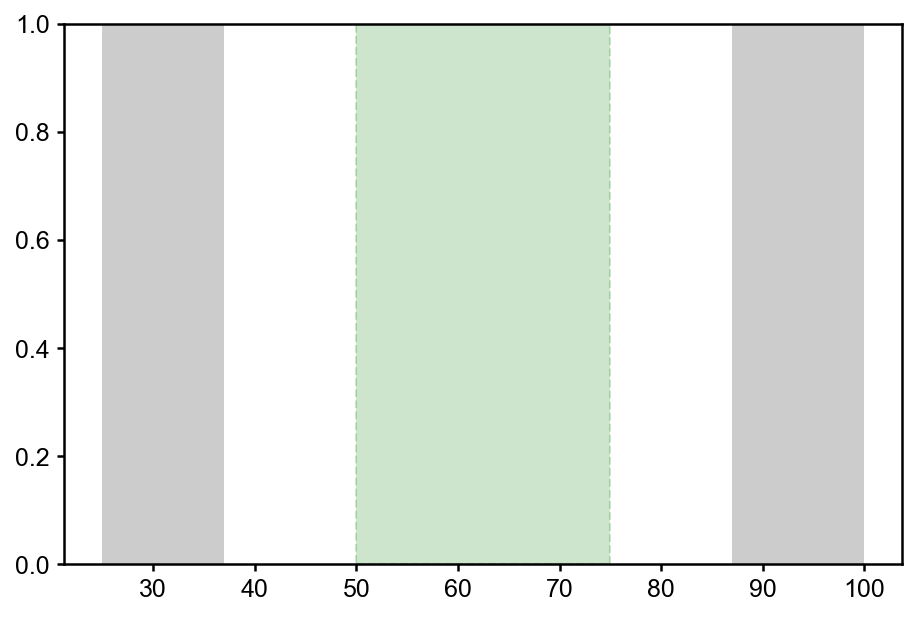

In [57]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.axvspan(50, 75, alpha=0.2, color='g', ls='--', label='Impulse region')
ax.axvspan(25, 37, alpha=0.2, color='k', ls='none', label='Noise region')
ax.axvspan(87, 100, alpha=0.2, color='k', ls='none')
ax.plot(nd.deconvolved_pulses[inds][:10, :].T)
ax.set_xlim([0, 124])
ax.set_xlabel('Time step')
ax.set_ylabel('Impulse [keV/c]')
ax.legend()

### Cut based on goodness of fit

In [58]:
chi2_cut = 1.5

# z_cut = 1
ndof = len(template) - 1
# alpha = (1 - stats.norm.cdf(z_cut))*2
# pvals = 1. - stats.chi2.cdf(nd.chi2, df=ndof)
chi2_mask = np.zeros(nd.chi2.shape, dtype=bool)
chi2_mask[nd.chi2/ndof < chi2_cut] = True

<>:91: SyntaxWarning: invalid escape sequence '\c'
<>:91: SyntaxWarning: invalid escape sequence '\c'
/var/folders/js/qsyryzx92mn4n3v5xr4_1_n40000gn/T/ipykernel_32545/485919643.py:91: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('2D noise and $\chi^2$ cut')


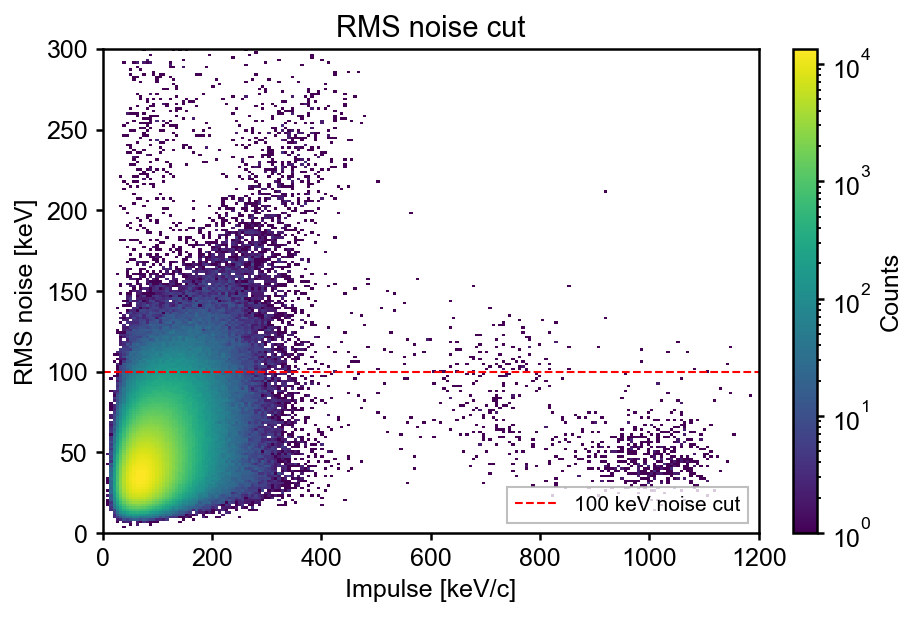

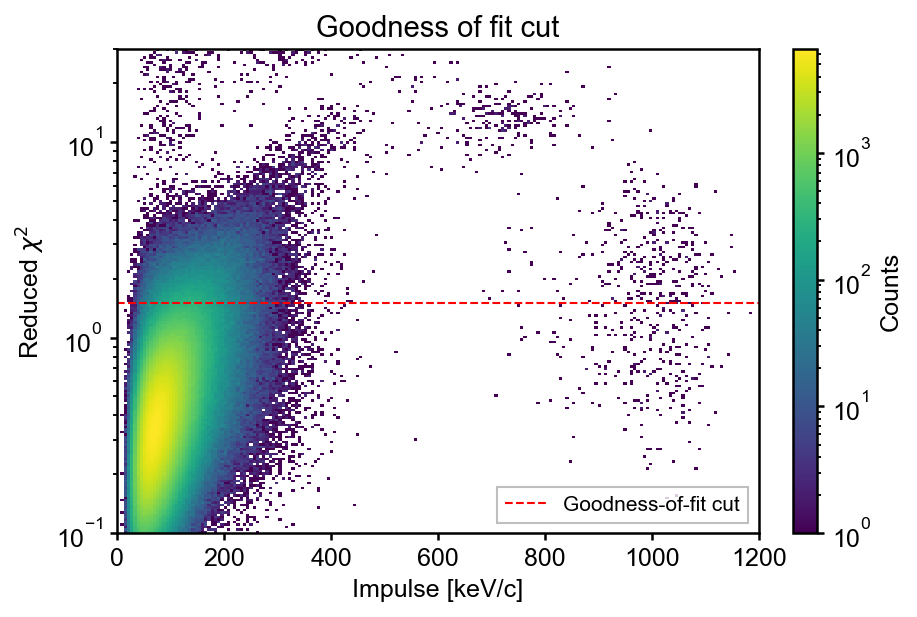

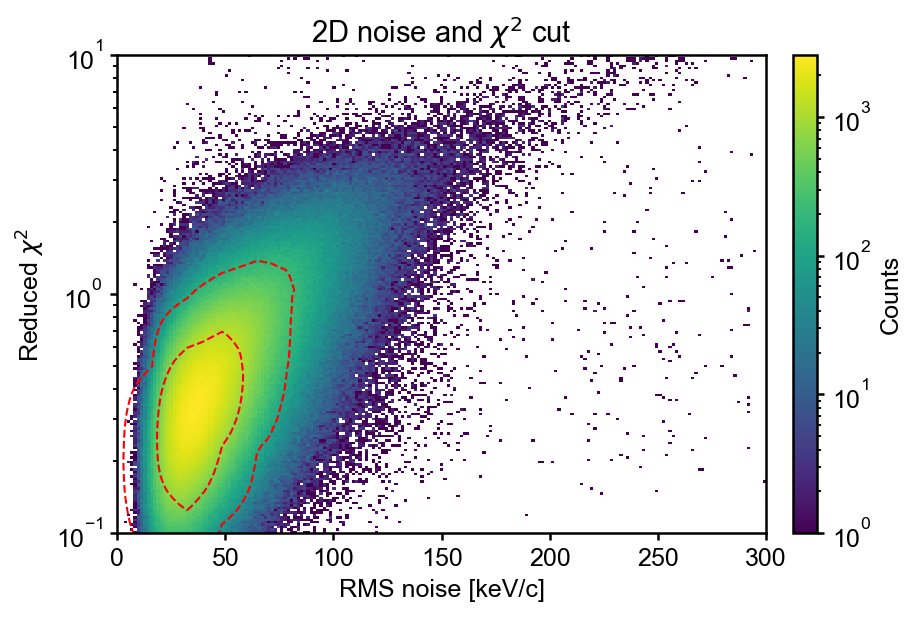

In [59]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.linspace(0, 300, 200)
bins_x = np.linspace(0, 1200, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.impulse_rms, bins=(bins_x, bins_y), norm='log')
ax.axhline(noise_thresh, ls='--', color='red', label='{:.0f} keV noise cut'.format(noise_thresh))
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('RMS noise [keV]')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('RMS noise cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.logspace(-1, np.log10(30), 200)
bins_x = np.linspace(0, 1200, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.chi2/ndof, bins=(bins_x, bins_y), norm='log')
ax.axhline(chi2_cut, ls='--', color='red', label='Goodness-of-fit cut')
ax.set_yscale('log')
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel(r'Reduced $\chi^2$')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('Goodness of fit cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

# x = np.abs(nd.impulse_rms)
# logy = np.log10(nd.chi2/ndof)
# stacked = np.vstack([x, logy])
# kde = stats.gaussian_kde(stacked, bw_method="scott")

# x_min, x_max = 0, 1600
# y_min, y_max = 2e-2, 1e1
# nx, ny = 100, 100

# xc = np.linspace(x_min, x_max, nx)
# yc_log = np.linspace(np.log10(y_min), np.log10(y_max), ny)
# X, YLOG = np.meshgrid(xc, yc_log)

# # Evaluate KDE on the grid
# grid = np.vstack([X.ravel(), YLOG.ravel()])
# Z = kde(grid).reshape(YLOG.shape)

# # Convert KDE to an approximate PDF over the grid for enclosed-probability contours
# dx = xc[1] - xc[0]
# dy = yc_log[1] - yc_log[0]
# pdf = Z * dx * dy

# pdf_flat = pdf.ravel()

# idx = np.argsort(pdf_flat)[::-1]
# cdf = np.cumsum(pdf_flat[idx])

# # Levels corresponding to 68% and 95% enclosed probability (HDR contours)
# levels_pdf = []
# for frac in (0.68, 0.95, 0.997):
#     j = min(np.searchsorted(cdf, frac), len(idx) - 1)
#     levels_pdf.append(pdf_flat[idx][j])

# l1, l2, l3 = sorted(levels_pdf)
# levels_fill = [l1, l2, l3]

# Y = 10**YLOG

# interp = RegularGridInterpolator(
#     (yc_log, xc), Z,
#     method="linear",
#     bounds_error=False,
#     fill_value=-np.inf,
# )

# x, y are your unbinned data arrays, shape (N,)
pts = np.column_stack([np.log10(nd.chi2/ndof), nd.impulse_rms])
mask_inside = interp(pts) >= levels_pdf[1]

cs = ax.contour(
        X, Y, pdf,
        levels=levels_fill,
        colors='red',
        linestyles='--'
    )

bins_y = np.logspace(-1, 1, 200)
bins_x = np.linspace(0, 300, 200)
h = ax.hist2d(nd.impulse_rms, nd.chi2/ndof, bins=(bins_x, bins_y), norm='log')
# ax.axhline(chi2_cut, ls='--', color='red', label='Goodness-of-fit cut')
# ax.axvline(noise_thresh, ls='--', color='blue', label='{:.0f} keV noise cut'.format(noise_thresh))
ax.set_yscale('log')
ax.set_xlabel('RMS noise [keV/c]')
ax.set_ylabel(r'Reduced $\chi^2$')
# ax.legend(fontsize=10, loc='lower right')
ax.set_title('2D noise and $\chi^2$ cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

### Histogram the results

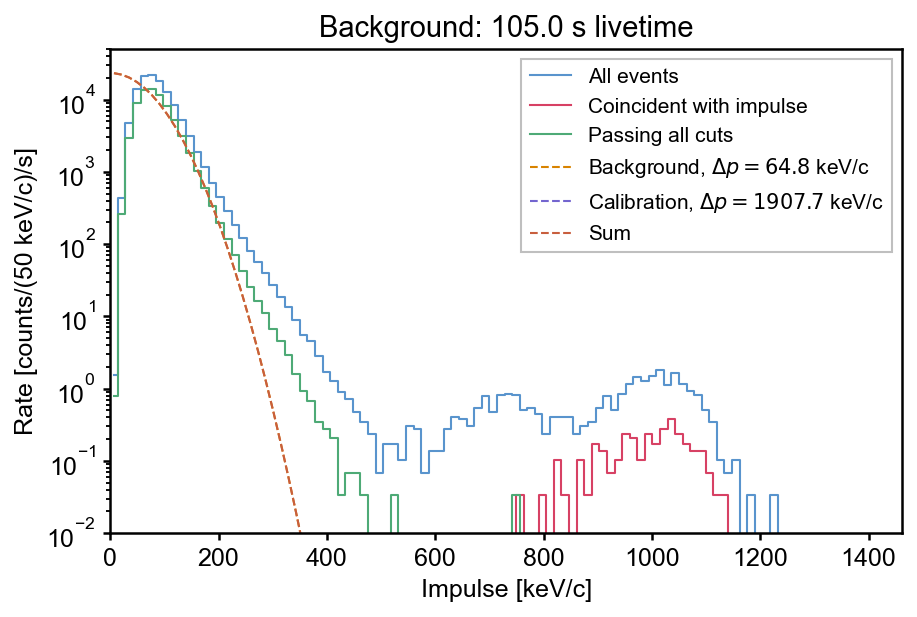

In [61]:
bin_edges = np.linspace(0, 1400, 101)

counts_all, _ = np.histogram(np.abs(nd.impulses), bins=bin_edges)
counts_acc, _ = np.histogram(np.abs(nd.impulses[mask_inside & adj_mask & res_mask & det_mask & ~kick_mask]), bins=bin_edges)

bins = (bin_edges[1:] + bin_edges[:-1])/2.
bin_width = bin_edges[1] - bin_edges[0]  # keV/c per bin

# Compute total observation time: number of search windows * search window duration
total_time = len(nd.impulses) * nd.search_window * sum(mask_inside & adj_mask & res_mask & det_mask)/len(chi2_mask)

# Scale to rate per 50 keV/c per second
scale_factor = (50. / bin_width) / total_time
rate_all = counts_all * scale_factor
rate_acc = counts_acc * scale_factor

ppb = len(nd.impulses)/len(bins)
exp = np.floor(np.log10(ppb))
coeff = 7*np.ceil(ppb/10**exp)

fit_ind = int(2*np.argmax(counts_all))
peak_ind = np.argmin(np.abs(bins - 700))

def half_gaus(x, A, sigma):
    return A*np.exp(-x**2/2/sigma**2)

def gaus(x, A, mu, sigma):
    return A*np.exp(-(x - mu)**2/2/sigma**2)

p, _ = curve_fit(half_gaus, bins[fit_ind:], rate_acc[fit_ind:], p0=(rate_acc.max(), np.std(nd.impulses[~np.isnan(nd.impulses)])))
p2, _ = curve_fit(gaus, bins[peak_ind:], rate_acc[peak_ind:], p0=(100, 100, 1000))

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, rate_all, where='mid', label='All events')
# ax.step(bins, np.histogram(np.abs(nd.impulses[~res_mask]), bins=bin_edges)[0] * scale_factor, label='Rejected by fit cut')
# ax.step(bins, np.histogram(np.abs(nd.impulses[~noise_mask & res_mask]), bins=bin_edges)[0] * scale_factor, label='Rejected by noise cut')
# ax.step(bins, np.histogram(np.abs(nd.impulses[~chi2_mask & noise_mask & ~res_mask]), bins=bin_edges)[0] * scale_factor, label=r'Rejected by $\chi^2$ cut')
ax.step(bins, np.histogram(np.abs(nd.impulses[chi2_mask & noise_mask & adj_mask & res_mask & det_mask & kick_mask]), bins=bin_edges)[0] * scale_factor, \
        label='Coincident with impulse')
ax.step(bins, rate_acc, where='mid', label='Passing all cuts')
ax.plot(bins, half_gaus(bins, *p), '--', label='Background, $\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.plot(bins, gaus(bins, *p2), '--', label='Calibration, $\\Delta p={:.1f}$ keV/c'.format(np.abs(p2[2])))
ax.plot(bins, half_gaus(bins, *p) + gaus(bins, *p2), '--', label='Sum')
ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([1e-2, 5e4])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
ax.set_yscale('log')
ax.legend()
ax.set_title('Background: {:.1f} s livetime'.format(total_time))

if data_type == 'background':
    rate_bkg = np.copy(rate_acc)
    imp_spec_bkg = np.copy(bins)
    total_time_bkg = total_time

# p, _ = curve_fit(half_gaus, imp_spec_bkg[fit_ind:], rate_bkg[fit_ind:], p0=(rate_bkg.max(), np.std(nd.impulses[~np.isnan(nd.impulses)])))

In [13]:
if data_type == 'xenon':
    from signal_models import gas_collision_spectrum
    
    # Signal model parameters (adjust as needed)
    sphere_temperature_K = 650.  # Nanosphere temperature
    xe_partial_pressure_fraction = 1.  # Xenon partial pressure fraction
    
    bin_edges = np.linspace(0, 800, 101)

    counts_all, _ = np.histogram(nd.impulses, bins=bin_edges)
    counts_acc, _ = np.histogram(nd.impulses[chi2_mask & noise_mask], bins=bin_edges)

    bins = (bin_edges[1:] + bin_edges[:-1])/2.
    bin_width = bin_edges[1] - bin_edges[0]  # keV/c per bin

    # Compute total observation time: number of search windows * search window duration
    total_time = len(nd.impulses) * nd.search_window  # seconds

    # Scale to rate per 50 keV/c per second
    scale_factor = (50 / bin_width) / total_time
    rate_all = counts_all * scale_factor
    rate_acc = counts_acc * scale_factor

    ppb = len(nd.impulses)/len(bins)
    exp = np.floor(np.log10(ppb))
    coeff = 7*np.ceil(ppb/10**exp)

    fit_ind = int(1.5*np.argmax(counts_all))

    def half_gaus(x, A, sigma):
        return A*np.exp(-x**2/2/sigma**2)

    # p, _ = curve_fit(half_gaus, bins[fit_ind:], rate_acc[fit_ind:], p0=(rate_acc.max(), np.std(nd.impulses[~np.isnan(nd.impulses)])))

    # Compute signal model
    pressure_mbar = np.mean(nd.pressures) * xe_partial_pressure_fraction
    signal_spectrum = gas_collision_spectrum(bins, pressure_mbar, p[1],
                                             temperature_K=sphere_temperature_K,
                                             diameter_nm=config['d_sphere_nm'])

    fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
    ax.step(bins, rate_acc, where='mid', label='Xenon data')
    ax.step(imp_spec_bkg, rate_bkg, where='mid', label='Background')
    ax.plot(bins, signal_spectrum, '--', label='Signal model ({:.0f} K, {:.1e} mbar)'.format(sphere_temperature_K, pressure_mbar))
    ax.plot(bins, half_gaus(bins, *p), '--', label='Background model ($\\Delta p={:.1f}$ keV/c)'.format(np.abs(p[1])))
    ax.plot(bins, signal_spectrum + half_gaus(bins, *p))
    ax.set_xlim([0, 1.05*np.amax(bins)])
    ax.set_ylim([1e-3, 5e4])
    ax.set_xlabel('Impulse [keV/c]')
    ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title('Xenon: {:.1f} s livetime'.format(total_time))

Fit threshold: 261.7 keV/c
Number of bins in fit region: 45
Bins with positive excess: 45 / 67
Mean excess in fit region: 4.08e+01
Measured pressure from gauge: 5.38e-07 mbar
Sphere diameter: 100.0 nm
Resolution: 81.1 keV/c

Model output at P=1e-09 mbar, T=293K:
  Max value: 1.38e+01
  Value at 300 keV/c: 6.53e-01

Best-fit results (linear method):
  T = 293 K:  P_Xe = 3.768e-06 mbar, chi2/ndof = 15350.0/44
  T = 1000 K: P_Xe = 4.752e-08 mbar, chi2/ndof = 30960.6/44



Text(0.5, 1.0, 'Best-fit Xe pressure (fit region: $q > 262$ keV/c)')

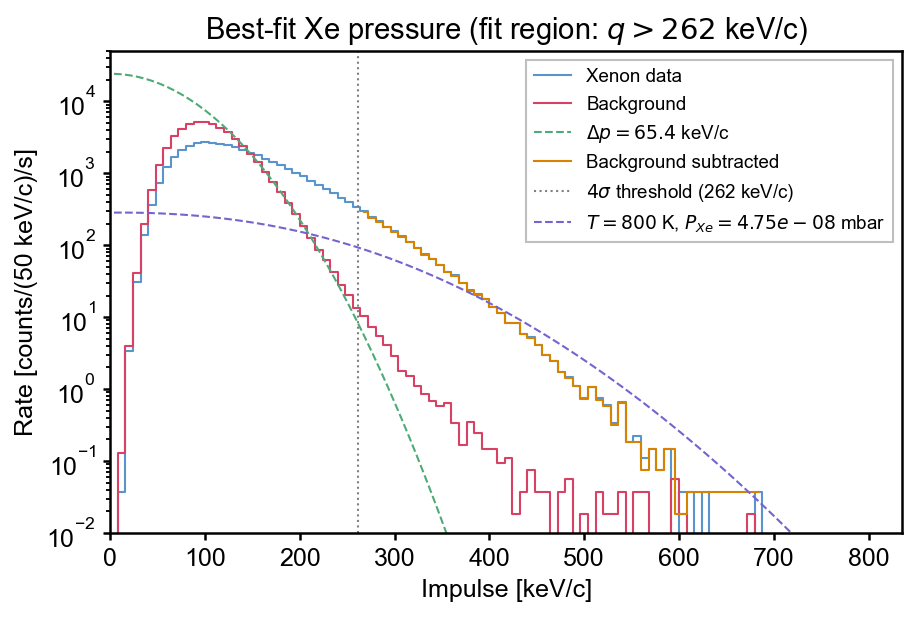

In [134]:
# Fit for best xenon pressure at two temperatures
from scipy.optimize import minimize_scalar, minimize

# Compute excess spectrum (xenon - background)
excess_spectrum = rate_acc - rate_bkg

# Only consider bins above 4 sigma from zero (using half-gaussian sigma)
sigma_fit = np.abs(p[1])
threshold = 4 * sigma_fit

# Also require positive excess to avoid negative values driving the fit
fit_mask = (bins > threshold) & (excess_spectrum > 0)

print(f"Fit threshold: {threshold:.1f} keV/c")
print(f"Number of bins in fit region: {np.sum(fit_mask)}")
print(f"Bins with positive excess: {np.sum((bins > threshold) & (excess_spectrum > 0))} / {np.sum(bins > threshold)}")
print(f"Mean excess in fit region: {np.mean(excess_spectrum[fit_mask]):.2e}")
print(f"Measured pressure from gauge: {np.mean(nd.pressures):.2e} mbar")
print(f"Sphere diameter: {config['d_sphere_nm']} nm")
print(f"Resolution: {resolution:.1f} keV/c")
print()

# Test the model at a known pressure to check scaling
test_pressure = 1e-9  # mbar
test_spectrum = gas_collision_spectrum(bins, test_pressure, resolution,
                                       temperature_K=293.,
                                       diameter_nm=config['d_sphere_nm'])
print(f"Model output at P={test_pressure:.0e} mbar, T=293K:")
print(f"  Max value: {np.max(test_spectrum):.2e}")
print(f"  Value at 300 keV/c: {test_spectrum[np.argmin(np.abs(bins-300))]:.2e}")
print()

# Simple linear fit: since spectrum scales linearly with pressure,
# find the best scaling factor
def fit_pressure_linear(temperature_K):
    # Get model at unit pressure (1 mbar)
    unit_model = gas_collision_spectrum(bins[fit_mask], 1.0, resolution,
                                        temperature_K=temperature_K,
                                        diameter_nm=config['d_sphere_nm'])
    
    # Linear least squares: excess = pressure * unit_model
    # Best pressure = sum(excess * model) / sum(model^2)
    data = excess_spectrum[fit_mask]
    
    # Weighted least squares
    weights = 1.0 / (np.sqrt(counts_acc[fit_mask] + 1) * scale_factor + 1e-10)
    
    numerator = np.sum(weights**2 * data * unit_model)
    denominator = np.sum(weights**2 * unit_model**2)
    
    best_pressure = numerator / denominator
    
    # Compute chi2
    model_at_best = best_pressure * unit_model
    chi2 = np.sum((weights * (data - model_at_best))**2)
    ndof = np.sum(fit_mask) - 1
    
    return best_pressure, chi2, ndof

# Fit at both temperatures
pressure_293K, chi2_293K, ndof_293K = fit_pressure_linear(293.)
pressure_1000K, chi2_1000K, ndof_1000K = fit_pressure_linear(1000.)

print(f"Best-fit results (linear method):")
print(f"  T = 293 K:  P_Xe = {pressure_293K:.3e} mbar, chi2/ndof = {chi2_293K:.1f}/{ndof_293K}")
print(f"  T = 1000 K: P_Xe = {pressure_1000K:.3e} mbar, chi2/ndof = {chi2_1000K:.1f}/{ndof_1000K}")
print()

# Compute best-fit spectra
spectrum_293K = gas_collision_spectrum(bins, pressure_293K, resolution,
                                       temperature_K=293.,
                                       diameter_nm=config['d_sphere_nm'])
spectrum_1000K = gas_collision_spectrum(bins, pressure_1000K, resolution,
                                        temperature_K=800.,
                                        diameter_nm=config['d_sphere_nm'])

# Plot results
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, rate_acc, where='mid', label='Xenon data')
ax.step(imp_spec_bkg, rate_bkg, where='mid', label='Background')
# ax.plot(bins, signal_spectrum, label='Signal model ({:.0f} K, {:.1e} mbar)'.format(sphere_temperature_K, pressure_mbar))
ax.plot(bins, half_gaus(bins, *p), '--', label='$\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.step(bins[fit_mask], excess_spectrum[fit_mask], where='mid', label='Background subtracted')
ax.axvline(threshold, ls=':', color='gray', label='$4\\sigma$ threshold ({:.0f} keV/c)'.format(threshold))
# ax.plot(bins, spectrum_293K, '--',
#         label='$T=293$ K, $P_{{Xe}}={:.2e}$ mbar'.format(pressure_293K))
ax.plot(bins, spectrum_1000K, '--', 
        label='$T=800$ K, $P_{{Xe}}={:.2e}$ mbar'.format(pressure_1000K))

ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([1e-2, 5e4])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=9)
ax.set_title('Best-fit Xe pressure (fit region: $q > {:.0f}$ keV/c)'.format(threshold))

2D fit results (pressure + temperature):
  Initial guess:        P = 1.561e-07 mbar, T = 1000 K
  Best-fit pressure:    P_Xe = 1.000e-03 mbar
  Best-fit temperature: T = 157 K
  chi2/ndof = 3329.9/56 = 59.46
  Optimizer converged: True



Text(0.5, 1.0, 'Best-fit Xe pressure and temperature')

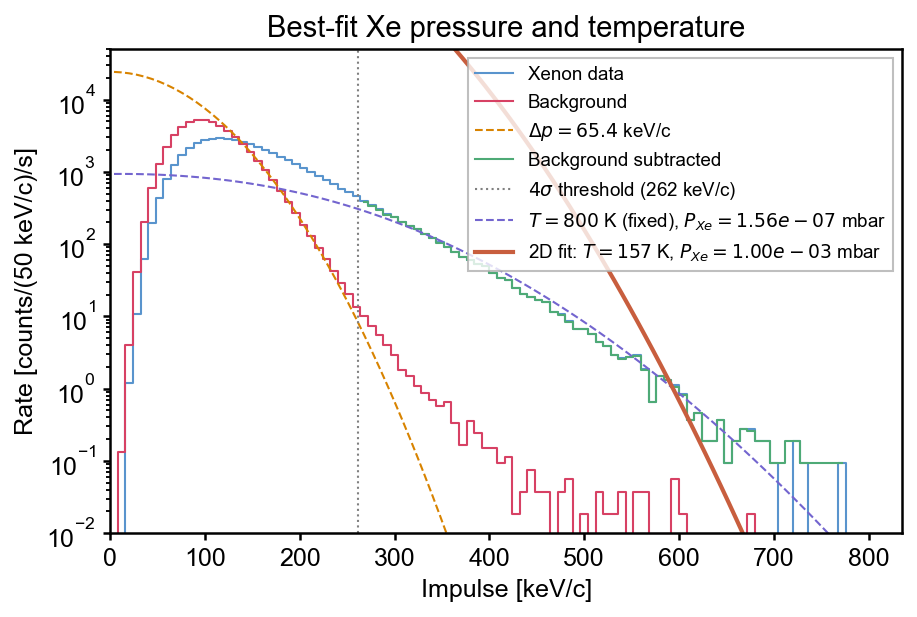

In [ ]:
# 2D fit: both pressure and temperature as free parameters
from scipy.optimize import minimize

def chi2_pressure_temperature(params):
    """Compute chi-squared for given log10(pressure) and temperature."""
    log_pressure, temperature = params
    pressure = 10**log_pressure
    
    # Get model spectrum
    model = gas_collision_spectrum(bins[fit_mask], pressure, resolution,
                                   temperature_K=temperature,
                                   diameter_nm=config['d_sphere_nm'])
    
    # Compute weighted chi2
    data = excess_spectrum[fit_mask]
    weights = 1.0 / (np.sqrt(counts_acc[fit_mask] + 1) * scale_factor + 1e-10)
    
    chi2 = np.sum((weights * (data - model))**2)
    return chi2

# Initial guess: use the 1000K fit result as starting point (log10 of pressure)
p0 = [np.log10(pressure_1000K), 1000.]

# Bounds: log10(pressure) from -12 to -3, temperature 100-5000 K
bounds = [(-12., -3.), (100., 5000.)]

# Run minimization with Nelder-Mead first for robustness, then polish with L-BFGS-B
result_nm = minimize(chi2_pressure_temperature, p0, method='Nelder-Mead',
                     options={'xatol': 1e-8, 'fatol': 1e-4, 'maxiter': 1000})
result = minimize(chi2_pressure_temperature, result_nm.x, method='L-BFGS-B', bounds=bounds)

best_log_pressure, best_temperature = result.x
best_pressure = 10**best_log_pressure
chi2_2d = result.fun
ndof_2d = np.sum(fit_mask) - 2  # 2 free parameters

print(f"2D fit results (pressure + temperature):")
print(f"  Initial guess:        P = {10**p0[0]:.3e} mbar, T = {p0[1]:.0f} K")
print(f"  Best-fit pressure:    P_Xe = {best_pressure:.3e} mbar")
print(f"  Best-fit temperature: T = {best_temperature:.0f} K")
print(f"  chi2/ndof = {chi2_2d:.1f}/{ndof_2d} = {chi2_2d/ndof_2d:.2f}")
print(f"  Optimizer converged: {result.success}")
print()

# Compute best-fit spectrum
spectrum_2d = gas_collision_spectrum(bins, best_pressure, resolution,
                                     temperature_K=best_temperature,
                                     diameter_nm=config['d_sphere_nm'])

# Recreate plot with 2D fit included
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, rate_acc, where='mid', label='Xenon data')
ax.step(imp_spec_bkg, rate_bkg, where='mid', label='Background')
ax.plot(bins, half_gaus(bins, *p), '--', color='C3', label='$\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.step(bins[fit_mask], excess_spectrum[fit_mask], where='mid', label='Background subtracted')
ax.axvline(threshold, ls=':', color='gray', label='$4\\sigma$ threshold ({:.0f} keV/c)'.format(threshold))
ax.plot(bins, spectrum_1000K, '--', color='C4',
        label='$T=800$ K (fixed), $P_{{Xe}}={:.2e}$ mbar'.format(pressure_1000K))
ax.plot(bins, spectrum_2d, '-', color='C5', linewidth=2,
        label='2D fit: $T={:.0f}$ K, $P_{{Xe}}={:.2e}$ mbar'.format(best_temperature, best_pressure))

ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([1e-2, 5e4])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=9)
ax.set_title('Best-fit Xe pressure and temperature')